In [121]:
import os
from nilearn import plotting

bids_path = '/DATAPOOL/MUSICNF/BIDS-MUSICNF'
backup_folder = '/DATAPOOL/MUSICNF/BIDS-MUSICNF/sourcedata/bidsonym'
sub_id = '17'

In [122]:
bidsonym_cmd = f'docker run --rm \
    -v {bids_path}:/bids_dataset \
    peerherholz/bidsonym /bids_dataset participant \
    --participant_label {sub_id} \
    --deid pydeface \
    --brainextraction bet \
    --bet_frac 0.5 \
    --skip_bids_validation'

In [123]:
# run the command
os.system(bidsonym_cmd)

Some packages in this Docker container are non-free
If you are considering commercial use of this container, please consult the relevant license:
https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Licence
Input data will not be checked for BIDS compliance.
Found the following session(s) for participant 17:
[]
250203-17:40:07,393 nipype.workflow INFO:
	 Workflow brainextraction_wf settings: ['check', 'execution', 'logging', 'monitoring']
250203-17:40:07,400 nipype.workflow INFO:
	 Running serially.
250203-17:40:07,401 nipype.workflow INFO:
	 [Node] Setting-up "brainextraction_wf.bet" in "/tmp/tmpg_7x1l09/brainextraction_wf/bet".
250203-17:40:07,405 nipype.workflow INFO:
	 [Node] Executing "bet" <nipype.interfaces.fsl.preprocess.BET>
250203-17:40:14,823 nipype.workflow INFO:
	 [Node] Finished "bet", elapsed time 7.399581s.
the following meta-data files will be checked:
/bids_dataset/participants.json
/bids_dataset/dataset_description.json
/bids_dataset/sub-17/fmap/sub-17_magnitude2.json
/bids_datase

0

## Check output

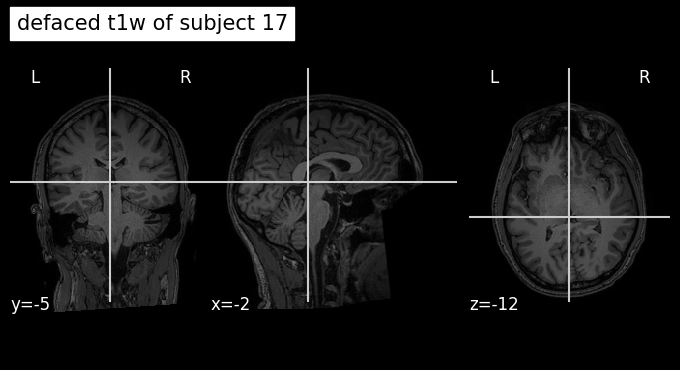

In [124]:
t1w_defaced = f'{bids_path}/sub-{sub_id}/anat/sub-{sub_id}_T1w.nii.gz'

plotting.plot_anat(t1w_defaced, title = f'defaced t1w of subject {sub_id}')

## Deface T2w
There is curently a bug in bidsonym that fails to identify the T2w image. This is a workaround.

In [38]:
# change folder permissions (manually)
f'sudo chmod -R g+rwx {backup_folder}/sub-{sub_id}'

'sudo chmod -R g+rwx /DATAPOOL/MUSICNF/BIDS-MUSICNF/sourcedata/bidsonym/sub-05'

In [125]:
# backup the original T2w image
os.system(f'cp {bids_path}/sub-{sub_id}/anat/sub-{sub_id}_T2w.nii.gz {backup_folder}/sub-{sub_id}/sub-{sub_id}_T2w.nii.gz')

0

In [126]:
# use the defaced T1w image as the mask for the T2w
t2w = f'{bids_path}/sub-{sub_id}/anat/sub-{sub_id}_T2w.nii.gz'

# use fslmaths to apply the mask
fslmaths_cmd = f'fslmaths {t2w} -mas {t1w_defaced} {t2w}'

os.system(fslmaths_cmd)

0

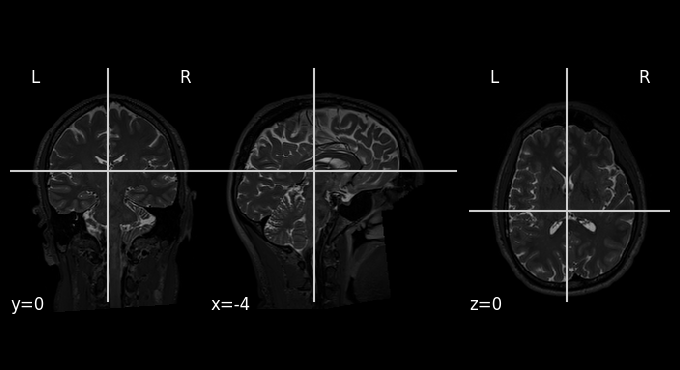

In [127]:
# view image using nilearn
plotting.plot_anat(t2w)